## GSM8K

This notebook reproduces the results for the GSM8K evaluations

In [1]:
import json
import outlines
import torch
from transformers import AutoTokenizer
from textwrap import dedent
from datasets import load_dataset
import re
from outlines.samplers import greedy

MODEL_NAME = "meta-llama/Meta-Llama-3-8B-Instruct"
# Load the dataset from HuggingFace
dataset = load_dataset("gsm8k", "main")
# You can inspect the dataset structure
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 7473
    })
    test: Dataset({
        features: ['question', 'answer'],
        num_rows: 1319
    })
})


In [2]:
dataset['train']

Dataset({
    features: ['question', 'answer'],
    num_rows: 7473
})

In [3]:
all_evals = list(dataset['test'])

In [4]:
model = outlines.models.transformers(
    MODEL_NAME,
    device='mps',
    model_kwargs={
        'torch_dtype': torch.bfloat16,
        'trust_remote_code': True
    })

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
example_question = [
    "There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done, there will be 21 trees. How many trees did the grove workers plant today?",
    "If there are 3 cars in the parking lot and 2 more cars arrive, how many cars are in the parking lot?",
    "Leah had 32 chocolates and her sister had 42. If they ate 35, how many pieces do they have left in total?"
]

In [6]:
example_response = [
    """{"reasoning": "There are 15 trees originally. Then there were 21 trees after some more were planted. So there must have been 21 - 15 = 6.", "answer": 6}""",
    """{"reasoning": "There are originally 3 cars. 2 more cars arrive. 3 + 2 = 5.", "answer": 5}""",
    """{"reasoning": "Originally, Leah had 32 chocolates. Her sister had 42. So in total they had 32 + 42 = 74. After eating 35, they had 74 - 35 = 39.","answer": 39"""
]


In [7]:
def create_prompt(question, tokenizer):
    messages = [
        {
            "role": "system",
            "content": dedent("""
            You are an expert in solving grade school math tasks. You will be presented with a grade-school math word problem and be asked to solve it.
            Before answering you should reason about the problem (using the "reasoning" field in the JSON response described below).
              
            You will always repond with JSON in the format described below:
            
            {"reasoning": <reasoning about the answer>, "answer": <final answer>}

            The "reasoning" field will contain your reasoning about the sequence of events, and the "answer" will contain the single letter representing the correct choice you are presented with.
            """)
        },]
    for i in range(len(example_question)):
        messages.append(
        {
            "role": "user",
            "content": """Question: {question}""".format(question=example_question[i])
        }
        )
        messages.append(
        {
            "role": "assistant",
            "content": example_response[i]        
        })
    messages.append(
        {
            "role": "user",
            "content": """Question: {question}", """.format(question=question)
        })
    messages.append(
        {
            "role": "assistant",
            "content": ""
        }
    )
    return tokenizer.apply_chat_template(messages, tokenize=False)

print(create_prompt(all_evals[5]['question'], tokenizer))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are an expert in solving grade school math tasks. You will be presented with a grade-school math word problem and be asked to solve it.
Before answering you should reason about the problem (using the "reasoning" field in the JSON response described below).

You will always repond with JSON in the format described below:

{"reasoning": <reasoning about the answer>, "answer": <final answer>}

The "reasoning" field will contain your reasoning about the sequence of events, and the "answer" will contain the single letter representing the correct choice you are presented with.<|eot_id|><|start_header_id|>user<|end_header_id|>

Question: There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done, there will be 21 trees. How many trees did the grove workers plant today?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

{"reasoning": "There are 15 trees originally. Then there were

In [8]:
from pydantic import BaseModel, Field, constr
from outlines.fsm.json_schema import build_regex_from_schema

class Response(BaseModel):
    reasoning: constr(max_length=1000)
    answer: int = Field(pattern=r'[1-9][0-9]{0,9}')


schema_regex = build_regex_from_schema(Response.schema_json())

In [9]:
all_evals[5]['question']

'Kylar went to the store to buy glasses for his new apartment. One glass costs $5, but every second glass costs only 60% of the price. Kylar wants to buy 16 glasses. How much does he need to pay for them?'

In [10]:
open_generator = outlines.generate.text(model, sampler=greedy())

In [11]:
open_generator(create_prompt(all_evals[5]['question'], tokenizer),max_tokens=256)

/Users/willkurt/miniconda3/envs/dottxt-ai/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/Users/willkurt/miniconda3/envs/dottxt-ai/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


'assistant\n\n{"reasoning": "Kylar wants to buy 16 glasses. The first glass costs $5, so the cost of the first glass is $5. The second glass costs 60% of $5, which is 0.6 x $5 = $3. The cost of the third glass is $5 again, and so on. So, the cost of the first, third, fifth,... glasses is $5 each, and the cost of the second, fourth, sixth,... glasses is $3 each. There are 8 glasses of each type, so the total cost is (8 x $5) + (8 x $3) = $40 + $24 = $64.", "answer": 64}'

In [12]:
re.search(schema_regex, create_prompt(all_evals[5]['question'], tokenizer))

<re.Match object; span=(939, 1091), match='{"reasoning": "There are 15 trees originally. The>

In [1]:
## Unstructured Generation

In [13]:
LAST = len(all_evals)
answer_regex = r'"answer":[ ]?([1-9][0-9]{0,9})'
answers = []
for ex_eval in all_evals[0:LAST]:
    raw_int = ex_eval['answer'].split('#### ')[1]
    raw_int = re.sub(",","",raw_int)
    answers.append(int(raw_int))

In [14]:
free_resp = [open_generator(create_prompt(all_evals[i]['question'], tokenizer), max_tokens=256) for i in range(LAST)]

In [15]:
free_resp[3]

'assistant\n\n{"reasoning": "James runs 3 sprints 3 times a week. So he runs 3 x 3 = 9 sprints a week. Each sprint is 60 meters, so he runs 9 x 60 = 540 meters a week.", "answer": 540}'

In [16]:
free_resp_answers = [int(result[1].upper()) if result else "" for result in [re.search(answer_regex,resp) for resp in free_resp]]

In [17]:
import numpy as np
np.mean([result[0] == result[1] for result in zip(free_resp_answers, answers)])

0.7717968157695224

## Structured Generation

In [18]:
structured_generator = outlines.generate.regex(model, schema_regex, sampler=greedy())

In [19]:
structured_resp = [structured_generator(create_prompt(all_evals[i]['question'], tokenizer)) for i in range(LAST)]

In [20]:
structured_resp[3]

'{"reasoning": "James runs 3 sprints 3 times a week. So he runs 3 x 3 = 9 sprints a week. Each sprint is 60 meters, so he runs 9 x 60 = 540 meters a week.", "answer": 540}'

In [21]:
structured_resp_answers = [int(result[1].upper()) if result else "" for result in [re.search(answer_regex,resp) for resp in structured_resp]]

In [22]:
import numpy as np
np.mean([result[0] == result[1] for result in zip(structured_resp_answers, answers)])

0.7778620166793025

Text(0.5, 1.0, 'GSM8K - Unstructured vs. JSON Structured\nmeta-llama/Meta-Llama-3-8B-Instruct')

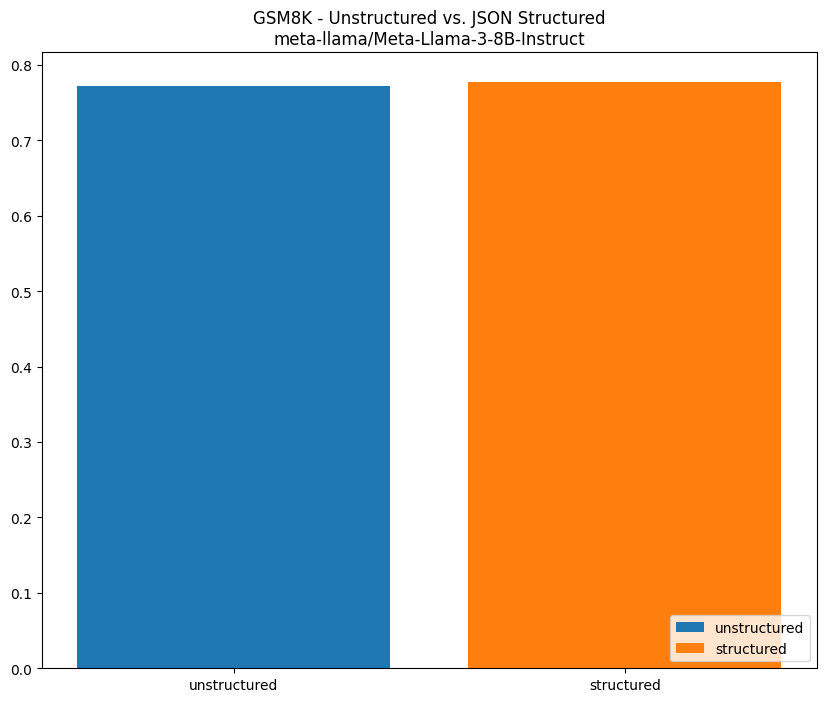

In [23]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,figsize=(10,8),facecolor='white')
ax.bar('unstructured',np.mean([result[0] == result[1] for result in zip(free_resp_answers, answers)]),label='unstructured')
ax.bar('structured',np.mean([result[0] == result[1] for result in zip(structured_resp_answers, answers)]),label='structured')
ax.legend(loc="lower right")
ax.set_title(f"GSM8K - Unstructured vs. JSON Structured\n{MODEL_NAME}")